## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from tkinter import filedialog
from tkinter import *
from roipoly import RoiPoly
from scipy.stats import mode
import cv2
from bpass import bpass
from imshift import imshift
import openpiv.tools as tools
import openpiv.process
import openpiv.scaling
import openpiv.validation
import openpiv.filters

/home/htmtri/miniconda3/lib/python3.7/site-packages/pywt/_utils.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


## Load imgs

In [2]:
root = Tk()

#root.directory = filedialog.askdirectory()

root.pc_name = filedialog.askopenfilename(initialdir = '.',
                                          title = "Select phase contrast img",
                                          filetypes = (("tiff files","*.tiff"),
                                          ("all files","*.*")))

root.load_name = filedialog.askopenfilename(initialdir = '.',
                                     title = "Select loadimg",
                                     filetypes = (("tiff files","*.tiff"),
                                                  ("all files","*.*")))
root.nulf_name = filedialog.askopenfilename(initialdir = '.',
                                     title = "Select nulfimg",
                                     filetypes = (("tiff files","*.tiff"),("all files","*.*")))


frame_c = plt.imread(root.pc_name)
org_b = plt.imread(root.nulf_name)
org_a = plt.imread(root.load_name)

root.withdraw()

''

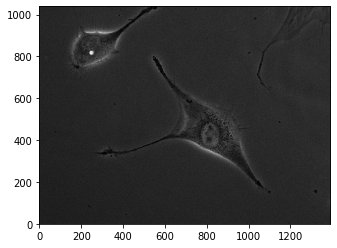

In [3]:
fig = plt.figure()
plt.imshow(frame_c,CMAP='gray',origin='lower')
plt.show(block=False)

## Crop ROI

In [4]:
c_uint8 = cv2.convertScaleAbs(frame_c,alpha=0.5)

showCrosshair = False
fromCenter = False

#drag from top left to bot right .press ESC to finish
rect = cv2.selectROI('Cell ROI',c_uint8,fromCenter, showCrosshair) 
recs = cv2.selectROI('Empty ROI',c_uint8,fromCenter, showCrosshair)

## bpass filter and stage drift

In [5]:
frame_b = bpass(org_b,lnoise=0,lobject=7,threshold=0.05*mode(org_b.flatten())[0])
frame_a = bpass(org_a,lnoise=0,lobject=7,threshold=0.05*mode(org_a.flatten())[0])
drift = imshift(frame_a,frame_b,recs)

In [6]:
cellimg = frame_c[int(rect[1]):int(rect[1]+rect[3]), int(rect[0]):int(rect[0]+rect[2])]
loadimg = frame_a[int(rect[1]):int(rect[1]+rect[3]), int(rect[0]):int(rect[0]+rect[2])]
nulfimg = frame_b[int(rect[1]+drift[1]):int(rect[1]+rect[3]+drift[1]), int(rect[0]+drift[0]):int(rect[0]+rect[2]+drift[0])]

In [7]:
%matplotlib qt
cimg = np.zeros([cellimg.shape[0],cellimg.shape[1],3],dtype=np.uint8)
cimg[:,:,0] = loadimg
cimg[:,:,1] = nulfimg
plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg[:,:,0].max())

## Cell Boundary Trace

In [8]:
%matplotlib qt
fig = plt.figure()
plt.imshow(cellimg,cmap='gray',vmin=0,vmax=0.5*cellimg.max())
plt.title("left click: line segment; right click or double click: close region")
plt.show(block=False)

cell_roi = RoiPoly(color='r',fig=fig,show_fig=False)

In [9]:
plt.figure()
plt.imshow(cellimg,cmap='gray',vmin=0,vmax=0.5*cellimg.max())
cell_roi.display_roi()
plt.title('With celltrace')
plt.show(block=False)

#plt.figure()
#plt.plot(cell_roi.x,cell_roi.y,color='r',linewidth=2.5)
#plt.plot(cell_roi.x + [cell_roi.x[0]],cell_roi.y + [cell_roi.y[0]],color='b')
#plt.show(block=False)
#cell_roi does not close boundary itself
cellx = np.array(cell_roi.x + [cell_roi.x[0]])
celly = np.array(cell_roi.y + [cell_roi.y[0]])

plt.figure()
plt.imshow(cimg,cmap='gray',vmin=0,vmax=0.5*cellimg.max())
plt.plot(cellx,celly,color='r')
plt.title('With celltrace')
plt.show(block=False)

## Loading processed imgs (start here if you had the preprocessed the imgs)

In [10]:
# IF IMAGES AND TRACE EXISTED, START FROM HERE. 
checkpoint = int(input('Does your tfm save file exist? 1(yes) 0(no)'))
#load save file:
if checkpoint==1: 
    npzlfile = np.load('testcell.npz')
    # print all npzfile field: npzfile.files
    # access a field in npzfile:
    # npzfile['cellTrace']
    cellTrace = npzlfile['cellTrace']
    cellx = cellTrace[:,0]
    celly = cellTrace[:,1]
    cellimg = npzlfile['cellimg']
    loadimg = npzlfile['loadimg']
    nulfimg = npzlfile['nulfimg']
    cimg = npzlfile['cimg']

Does your tfm save file exist? 1(yes) 0(no)0


## PIV

In [12]:
u, v , sig2noise= openpiv.process.extended_search_area_piv( nulfimg.astype(np.int32), 
                                                           loadimg.astype(np.int32), 
                                                           window_size=32, 
                                                           overlap=16, 
                                                           dt=0.02, 
                                                           search_area_size=48,
                                                           subpixel_method='gaussian',
                                                           sig2noise_method='peak2peak')

xm, ym = openpiv.process.get_coordinates(image_size=loadimg.shape, window_size=32, overlap=16)
xm = np.flipud(xm)
ym = np.flipud(ym)

xgrid = xm.flatten()
ygrid = ym.flatten()
grid = list(zip(xgrid,ygrid))

In [13]:
u1, v1, mask = openpiv.validation.sig2noise_val(u, v, sig2noise, threshold = 2) #noise-filter
u2, v2, mask = openpiv.validation.local_median_val(u1,v1,2,2) #smooth
uf, vf = openpiv.filters.replace_outliers(u2, v2, method='localmean', max_iter=10, tol=1e-3, kernel_size=2) 
#x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
xdispRaw=uf.flatten()
ydispRaw=vf.flatten()

/home/htmtri/miniconda3/lib/python3.7/site-packages/openpiv/validation.py:213: RuntimeWarning: invalid value encountered in greater
  ind = (np.abs( (u-um) ) > u_threshold) | (np.abs( (v-vm) ) > v_threshold)


In [14]:
plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgrid,ygrid,xdispRaw,ydispRaw,color='c',units='xy')
plt.plot(cellx,celly,color='r')
plt.show()

## Noise filter

In [41]:
# Define noise as standard deviation of displacement outside cell boundary
polygon = np.column_stack((cellx,celly))
path = mpltPath.Path(polygon)
inside = path.contains_points(grid,radius=1e-9)
xdrift = np.mean(xdispRaw[~inside])
ydrift = np.mean(ydispRaw[~inside])

xdispd = xdispRaw[inside] - xdrift
ydispd = ydispRaw[inside] - ydrift

dispm = np.sqrt(xdispRaw[~inside]**2 + ydispRaw[~inside]**2)
dispnoise = np.std(dispm)
dispmag = np.sqrt(xdispd**2 + ydispd**2)

realids = np.where(dispmag>0.5*dispnoise)

if np.size(realids)<0.1*np.size(np.where(inside==1)):
    print('Number of nodes with real displacement is too low')

In [44]:
xgridin = xgrid[inside]
ygridin = ygrid[inside]
xgridf = xgridin[realids]
ygridf = ygridin[realids]
gridf = list(zip(xgridf,ygridf))

xdisp = xdispd[realids]
ydisp = ydispd[realids]

%matplotlib qt

fig = plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgrid,ygrid,xdispRaw,ydispRaw,color='c',units='xy')
plt.quiver(xgridin,ygridin,xdispd,ydispd,color='r',units='xy')
plt.quiver(xgridin[realids],ygridin[realids],xdisp,ydisp,color='g',units='xy')
plt.plot(cellx,celly,color='r')
plt.title("Cyan: raw PIV, Red: dedrift, Green: filtered")
plt.show(block=False)

## Bogus 

In [45]:
## RUN THIS CELL BLOCK AGAIN AFTER RUNNNING NEXT CELL IF YOU STILL NEED TO REMOVE BOGUS IN MORE THAN ONE LOCATION
%matplotlib qt

fig = plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgridin[realids],ygridin[realids],xdisp,ydisp,color='c',units='xy')
plt.plot(cellx,celly,color='r')
plt.title("left click: line segment; right click or double click: close region")
plt.show(block=False)
bogusroi = RoiPoly(color='r',fig=fig,show_fig=False)

In [46]:
## RUN CELL BLOCK ABOVE AGAIN IF YOU STILL NEED TO REMOVE MORE BOGUS
bogusx = np.array(bogusroi.x + [bogusroi.x[0]])
bogusy = np.array(bogusroi.y + [bogusroi.y[0]])
polygon = np.column_stack((bogusx,bogusy))
#polygon = tuple(map(tuple,np.column_stack((bogusx,bogusy)))) 
path = mpltPath.Path(polygon)
inside = path.contains_points(gridf,radius=1e-9)
xdisp[inside] = 0
ydisp[inside] = 0
    
plt.figure()
plt.imshow(cimg,vmin=0,vmax=0.01*cimg.max())
plt.quiver(xgrid,ygrid,uf,vf,color='r',units='xy')
plt.quiver(xgridf,ygridf,xdisp,ydisp,color='c',units='xy')
plt.plot(cellx,celly,color='r')
plt.show(block=False)

## SAVING BLOCK

In [ ]:
np.savez('testcell',
        xgrid=xgrid,
        ygrid=ygrid,
        xdisp=xdisp,
        ydisp=ydisp,
        cellTrace=np.c_[cellx,celly],
        cellimg=cellimg,
        nulfimg=nulfimg,
        loadimg=loadimg,
        cimg=cimg)

## Solving for Force